In [1]:
import matplotlib.pyplot as plt
import matplotlib
import torch_geometric
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_dense_adj, k_hop_subgraph, dense_to_sparse, to_networkx
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
import torch
import torch.nn as nn
import torch.nn.init as init
from utils import plot_embeddings_overtime, plot_graph_and_subgraph

# Load the Karate Club graph
dataset = KarateClub()

In [2]:
data = dataset[0]
n = data.num_nodes

In [ ]:
G = to_networkx(data, to_undirected=False)

# Fixed layout with a random seed for consistency in the visualizations 
fixed_layout = nx.spring_layout(G, seed=42)  

# Graph shift operators

For a graph $\mathcal{G}=(X,A)$ with edge set $\mathcal{E}$, a **graph shift operator** (GSO) $\tilde{A}$ is a matrix such that:
$$
(i,j) \notin \mathcal{E} \text{ and } i\neq j \rightarrow \tilde{a}_{ij} = 0 
$$

Multiplying $\tilde{A}$ with $X$ has a local action on the neighborhood of each node. In fact, consider $X'=\tilde{A}X$ for node $i$:

$$
x_i'= (\tilde{A}X)_i = \sum_{j=0}^{N-1}\tilde{a}_{ji}x_j=\sum_{j\in \mathcal{N}(i)}\tilde{a}_{ji}x_j
$$

Consider now a linear transformation $W \in \mathbb{R}^{d_x\times d_h}$:

$$
h_i= (\tilde{A}XW)_i = \sum_{j=0}^{N-1}\tilde{a}_{ji}x_jW=\sum_{j\in \mathcal{N}(i)}\tilde{a}_{ji}x_jW
$$

We optain a **shared** and **localized** filter applied on a different space. 
This is called **graph diffusion**, which is a smoothing operation of the node features with respect to the graph topology. This operation is typically a low-pass filter on the graph signal. Spectral graph convolutions (not covered here) are able to perform high-pass filters, which are more useful for heterogeneous graphs, where connected nodes tend to have different labels.

If we add a nonlinear activation function $\phi$ 
we get 
$$
H=\phi(\tilde{A}XW)
$$
which are generally called **convolutional graph neural networks**, such as the famous GCN (Kipf and Welling, 2016).

Examples of GSO are:
- Laplacian matrix $L=D-A$
- Random walk matrix $R=D^{-1}A$

Note how in the $\tilde{A}XW$ operation, the network performs a **channel mixing** operation with $W$ and a **node mixing** operation with $\tilde{A}$. The graph convolution is therefore formed by steps:
- All nodes update their embeddings in parallel: $$x_i'=x_iW$$
- The transformed embeddings in each node's neighborhood are aggregated as a weighted average: $$h_i=\phi \left( \sum_{j\in \mathcal{N}(i)}\tilde{a}_{ji}x_j' \right)$$


Graphs do not have an order. In fact, matrices $X$ and $A$ could be permuted as $X'=PX$ and $A'=PAP^T$ resulting in the same graph. We can show that for our convolutional layer it holds: $$f(PX,PAP^T)=\phi(P\tilde{A}P^TPXW)=Pf(X,A)$$


#### Polynomial Graph Neural Networks

What happens if we take powers of a GSO? Consider the effect of $\tilde{A}^2X$ for the $i$-th node:


$$
(\tilde{A}^2X)_i = \sum_{j\in \mathcal{N}(i)} \tilde{a}_{ji}(\tilde{A}X)_j = 
    \sum_{j\in \mathcal{N}(i)} \sum_{k\in \mathcal{N}(j)}\tilde{a}_{ji}\tilde{a}_{kj}x_k
$$

This means that the second power aggregates features from nodes at a distance of 2 from the node, and the $k$-th power will aggregated features at a distance of $k$.

With this remark we can increase the receptive field of the filtering and can define the so-called **polynomial graph neural network** function for a certain order $k$: 

$$
H^{(k)} = \phi \left( \sum_{k=0}^{K}\tilde{A}^kXW^{(k)} \right)
$$

*Sources: "Alice’s Adventures in a differentiable wonderland", Simone Scardapane (2024), "Geometric Deep Learning: Grids, Groups, Graphs, Geodesics, and Gauges", Bronstein et. al (2021)*

# GSO visualisations

Let's take $A,A^2$ and $A^3$ and visualize the graph obtained using the GSO as adjacency matrix $\mathcal{G}=(X,\tilde{A})$. This allows us to see the neighborhood considered by each node for each power of the GSO.

In [4]:

A = to_dense_adj(data.edge_index)[0]
A2 = A@A
A3 = A2@A

# let's focus on node 16
node = 16

In [5]:
# Note that we take the **1-hop neighborhood** all the time!
# For each of those, we create a PyG graph. 
subset1, edge_index1, mapping1, edge_mask1 = k_hop_subgraph(node, num_hops=1, edge_index= dense_to_sparse(A)[0], relabel_nodes=True)

data_G1 = Data(x=data.x[subset1], edge_index=edge_index1)

subset2, edge_index2, mapping2, edge_mask2 = k_hop_subgraph(node, num_hops=1, edge_index=dense_to_sparse(A2)[0], relabel_nodes=True)
data_G2 = Data(x=data.x[subset2], edge_index=edge_index2)

subset3, edge_index3, mapping3, edge_mask3 = k_hop_subgraph(node, num_hops=1, edge_index=dense_to_sparse(A3)[0], relabel_nodes=True)
data_G3 = Data(x=data.x[subset3], edge_index=edge_index3)

In [6]:
# Let's now make Networkx graphs to visualize them.
# (Please note that I re-label the nodes when calling k_hop_subgraph and re-label them to their original 
# labels before plotting. This is because initializing a Networkx graph with node numbers that were not starting 
# from 0 gave me issues. If you have better ideas, let me know!)
G1 = to_networkx(data_G1, to_undirected=False)
node_mapping = {i: subset1[i].item() for i in range(subset1.shape[0])}
G1 = nx.relabel_nodes(G1, node_mapping)


G2 = to_networkx(data_G2, to_undirected=False)
node_mapping = {i: subset2[i].item() for i in range(subset2.shape[0])}
G2 = nx.relabel_nodes(G2, node_mapping)

G3 = to_networkx(data_G3, to_undirected=False)
node_mapping = {i: subset3[i].item() for i in range(subset3.shape[0])}
G3 = nx.relabel_nodes(G3, node_mapping)

The 1-hop neighborhood of node 16 with $\tilde{A}=A$ is trivial:

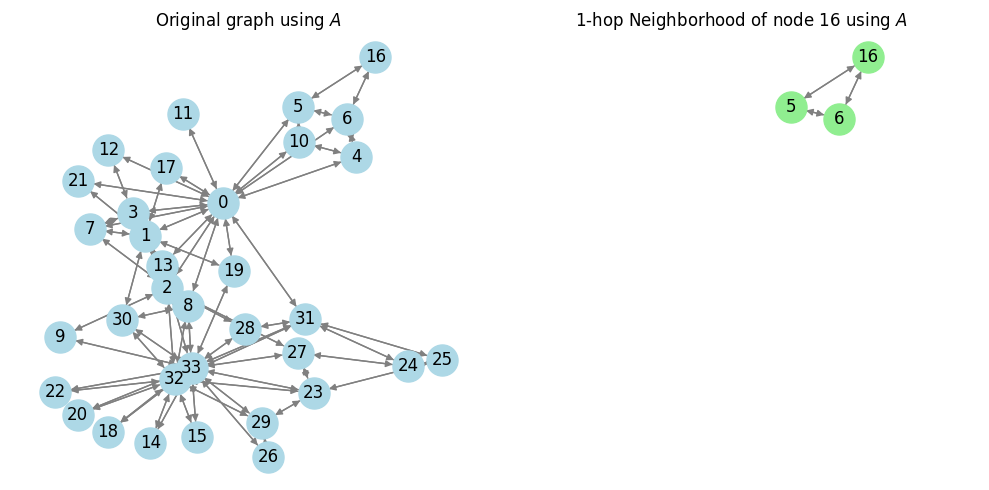

In [7]:
plot_graph_and_subgraph(G=G, G_sub=G1, fixed_layout=fixed_layout, title=rf'1-hop Neighborhood of node {node} using $A$')

The 1-hop neighborhood of node 16 with $\tilde{A}=A^2$ becomes interesting; every node at distance $2$ in the origianl graph, becomes now a direct neighbor!

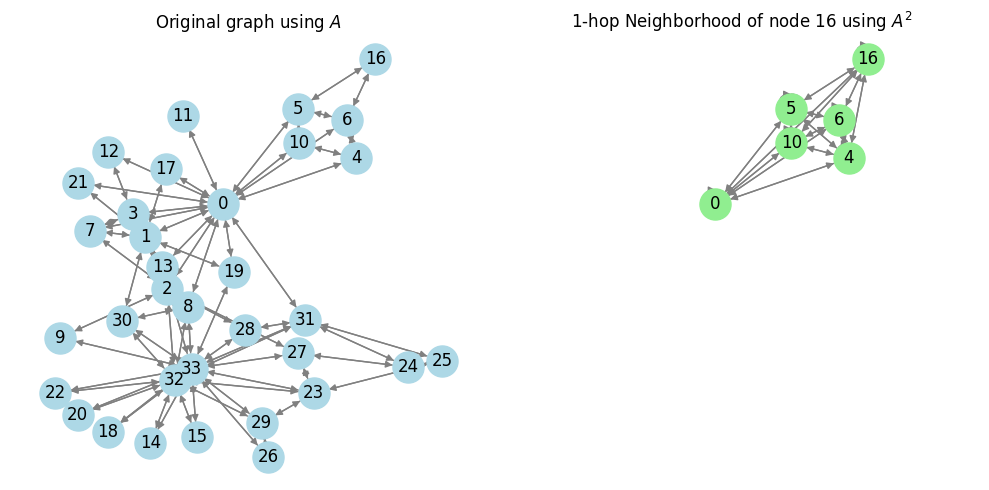

In [8]:
plot_graph_and_subgraph(G=G, G_sub=G2, fixed_layout=fixed_layout, title=rf'1-hop Neighborhood of node {node} using $A^2$')

Similarly, with $\tilde{A}=A^3$, every node at distance $3$ in the original graph, is now a direct neighbor:

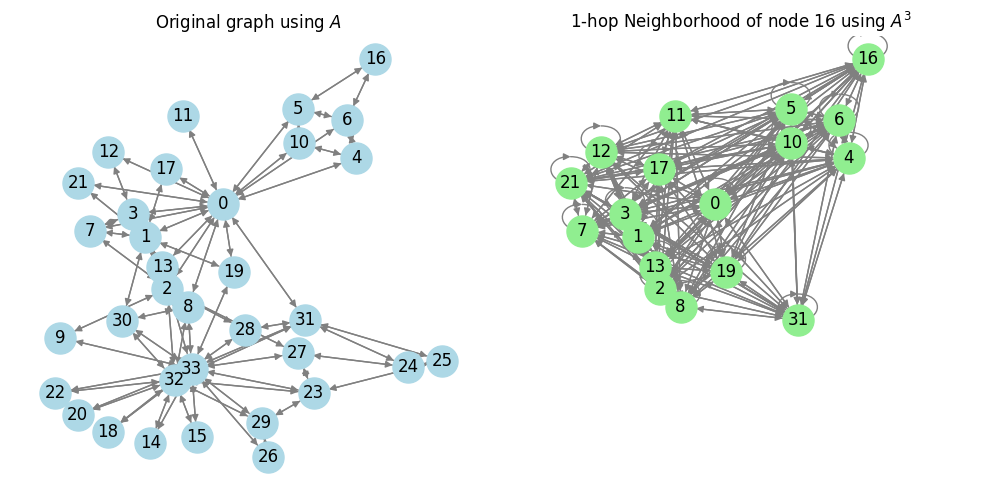

In [9]:
plot_graph_and_subgraph(G=G, G_sub=G3, fixed_layout=fixed_layout, title=rf'1-hop Neighborhood of node {node} using $A^3$')

# Training a neural network that uses a GSO: the GCN example

The Graph Convolutional Network (GCN) by Thomas N. Kipf and Max Welling, uses $\tilde{A}=\bar{D}^{-\frac{1}{2}} \bar{A} \bar{D}^{-\frac{1}{2}}$, where
$\bar{A}=A+I_n$ is the adjacency with self-loops and $\bar{D}=\bar{A}I_n$ is its degree matrix. 

The GCN layer is then defined as: 
$$
X^{(l+1)}=\phi \left( \bar{D}^{-\frac{1}{2}} \bar{A} \bar{D}^{-\frac{1}{2}} X^{(l)} W \right)
$$
where $W \in \mathbb{R}^{d_x\times d_h}$ is a trainable linear transformation and $\phi$ is some activation function. 


To increase the receptive field, instead of using polynomial layers, we can stack multiple GCN layers: 

$$
  \begin{aligned}
    H^{(0)} & = X \\
    H^{(l)} & = \phi \left( \tilde{A}H^{(l-1)}W^{(l)} \right)
  \end{aligned}
$$

In [11]:
class GCNLayer(nn.Module):
    def __init__(self, A, in_size, out_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        tilde_A = A + torch.eye(n)
        tilde_D = torch.diag((tilde_A @ torch.ones(n,))**-0.5)
        self.A_norm = tilde_D @ tilde_A @ tilde_D

        self.W = nn.Parameter(init.xavier_normal_(torch.empty(in_size, out_size)))

    def forward(self, x):
        h = x @ self.W
        return self.A_norm @ h
    
class GCNModel(nn.Module):
    def __init__(self, A, in_size, hidden_sizes, classes, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layers = nn.ModuleList()
        layers = len(hidden_sizes)

        for l in range(layers):
            hidden_size = hidden_sizes[l]
            self.layers.append(GCNLayer(A=A, in_size=in_size, out_size=hidden_size))
            self.layers.append(nn.Tanh())
            in_size = hidden_size

        self.layers.append(nn.Linear(hidden_size, classes))

    def forward(self, x):
        # apply all GCN layers and the classifier head
        for l in self.layers:
            x = l(x)

        return x
    
    def get_embeddings(self,x):
        # apply all GCN layers but NOT the classifier to obtain the embeddings.
        for l in self.layers[:-1]:
            x = l(x)
        return x
        

Let's set the last embedding dimension to be $2$, so that we can directly visualize what the neural network is learning:

In [56]:
criterion = torch.nn.CrossEntropyLoss()
gcn = GCNModel(A=A, in_size=n, hidden_sizes=[4,2], classes=dataset.num_classes)
optimizer = torch.optim.Adam(gcn.parameters(),lr=0.005)

And finally, let's train the network to recognize the $4$ labels of the dataset (ignoring the overfitting issue for our purposes).

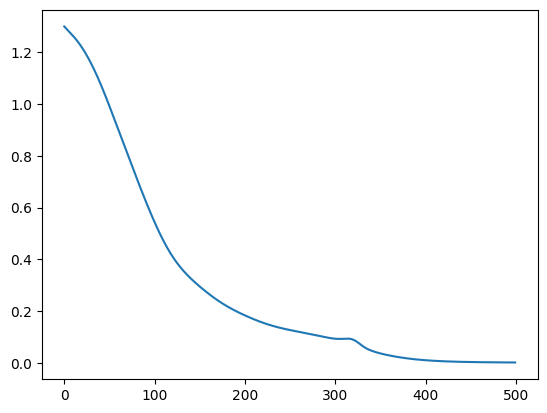

In [57]:
losses = []
epochs = 500

plotting_epochs = [0, 10, 50, 100, 200, 499]
embeddings = []
for i in range(epochs):
    gcn.train()
    out = gcn(data.x)

    loss = criterion(out,data.y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    if i in plotting_epochs:
        with torch.no_grad():
            gcn.eval()
            embeddings.append(gcn.get_embeddings(data.x))


plt.plot(losses)

### Embeddings visualisation 

During the training, we stored the intermediate 2-D embeddings that the network was learning at specific iterations. Let's plot them:

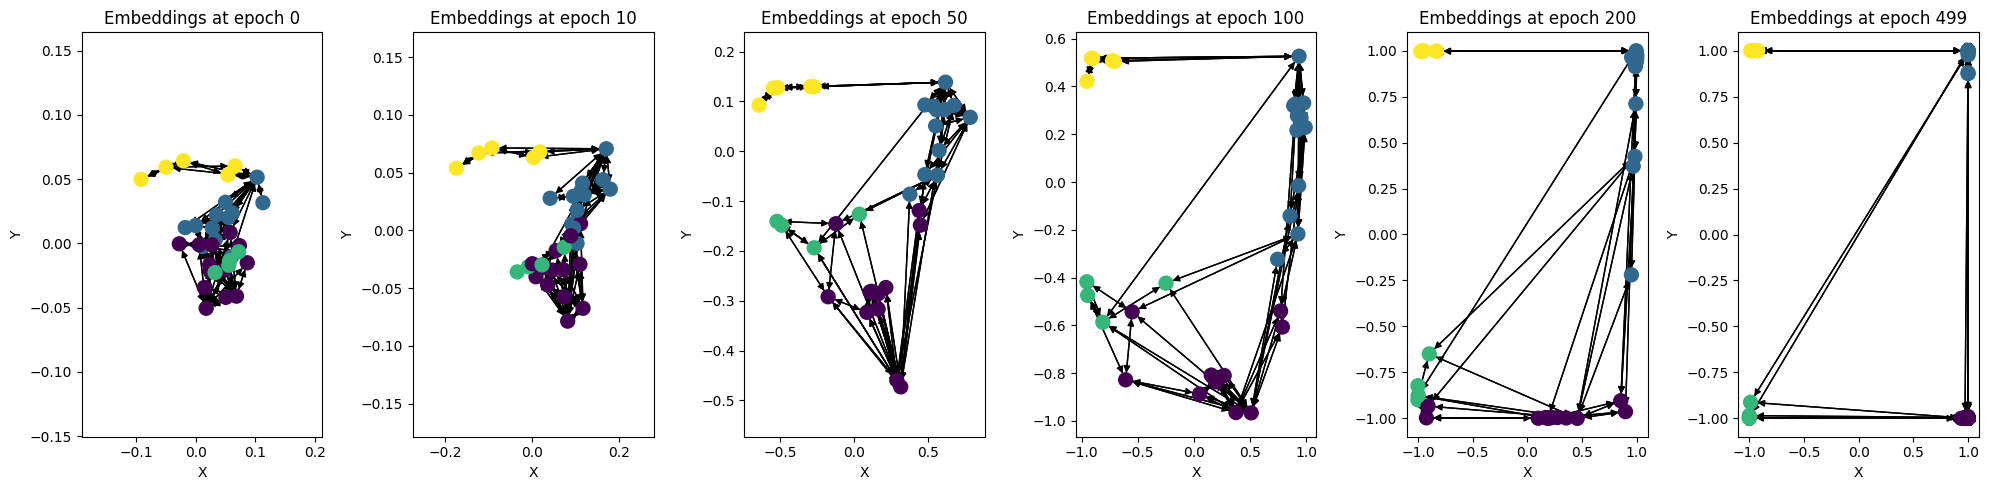

In [58]:
plot_embeddings_overtime(graph_data=data, embeddings=embeddings, plotting_epochs=plotting_epochs)

Quite remarkable, right?

# Let's train a polynomial GCN network

Let's take the graph shift operator used by GCN and define a polynomial GNN as follows:

$$
H = \text{tanh}\left( \sum_{k=0}^K \tilde{A}^kXW^{(k)}\right) = \text{tanh}\left( \sum_{k=0}^K (\bar{D}^{-\frac{1}{2}} \bar{A} \bar{D}^{-\frac{1}{2}})^k XW^{(k)}\right)
$$

We will use $K=2$ and the embedding dimension set to $2$, such that we can visualize the results directly. 
Using the 2nd power of the GSO, our network will have a receptive field for each node $i$ equal to $\mathcal{N}_{i,2}$, i.e all the nodes at a distance of up to 2 from $i$. 
The receptive field can be informally defined as the smallest set of nodes that conditions the layer's output for node $i$. Nodes at a distance $>2$ are unaware of each other. When interactions with nodes at a greater distance than the one enabled by the receptive field are useful for our task, we encounter the **under reaching** issue of GNNs. 

In [59]:
class PolyGCN(nn.Module):
    def __init__(self, gso, order, in_size, out_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.k = order
        # learnable weights, we will apply them in parallel as the sums are independent 
        self.Ws = nn.Parameter(init.xavier_normal_(torch.empty(order, in_size, out_size))) # [order, in, out]
        # generate tensor of GSOs
        self.gsos = [gso]
        for i in range(1, order):
            self.gsos.append(self.gsos[i-1] @ gso)
        self.gsos = torch.stack(self.gsos, dim=0) # [order, N, N]

        self.activation = nn.Tanh()
        self.classifier = nn.Linear(out_size, dataset.num_classes) # classifier head

    def forward(self, x):
        embeddings = (self.gsos @ (x @ self.Ws)).sum(dim=0) # here we take advantage of the parallelism
        return self.classifier(self.activation(embeddings))
    
    def get_embeddings(self, x):
        return self.activation((self.gsos @ (x @ self.Ws)).sum(dim=0))

In [60]:
tilde_A = A + torch.eye(n)
tilde_D = torch.diag((tilde_A @ torch.ones(n,))**-0.5)
gso = tilde_D @ tilde_A @ tilde_D

polygcn = PolyGCN(gso=gso, order=2, in_size=34, out_size=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(polygcn.parameters(),lr=0.008)

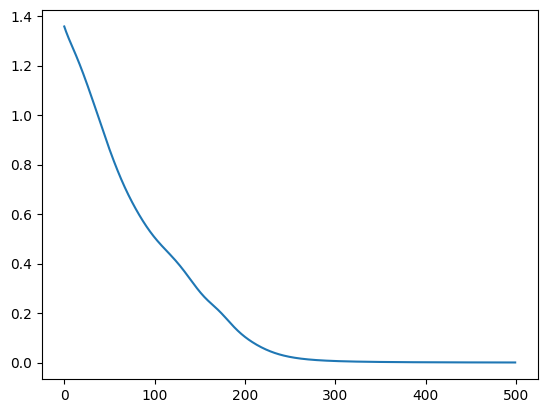

In [61]:
losses = []
epochs = 500

plotting_epochs = [0, 10, 50, 100, 200, 499]
embeddings = []
for i in range(epochs):
    polygcn.train()
    out = polygcn(data.x)

    loss = criterion(out,data.y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    if i in plotting_epochs:
        with torch.no_grad():
            polygcn.eval()
            embeddings.append(polygcn.get_embeddings(data.x))


plt.plot(losses)

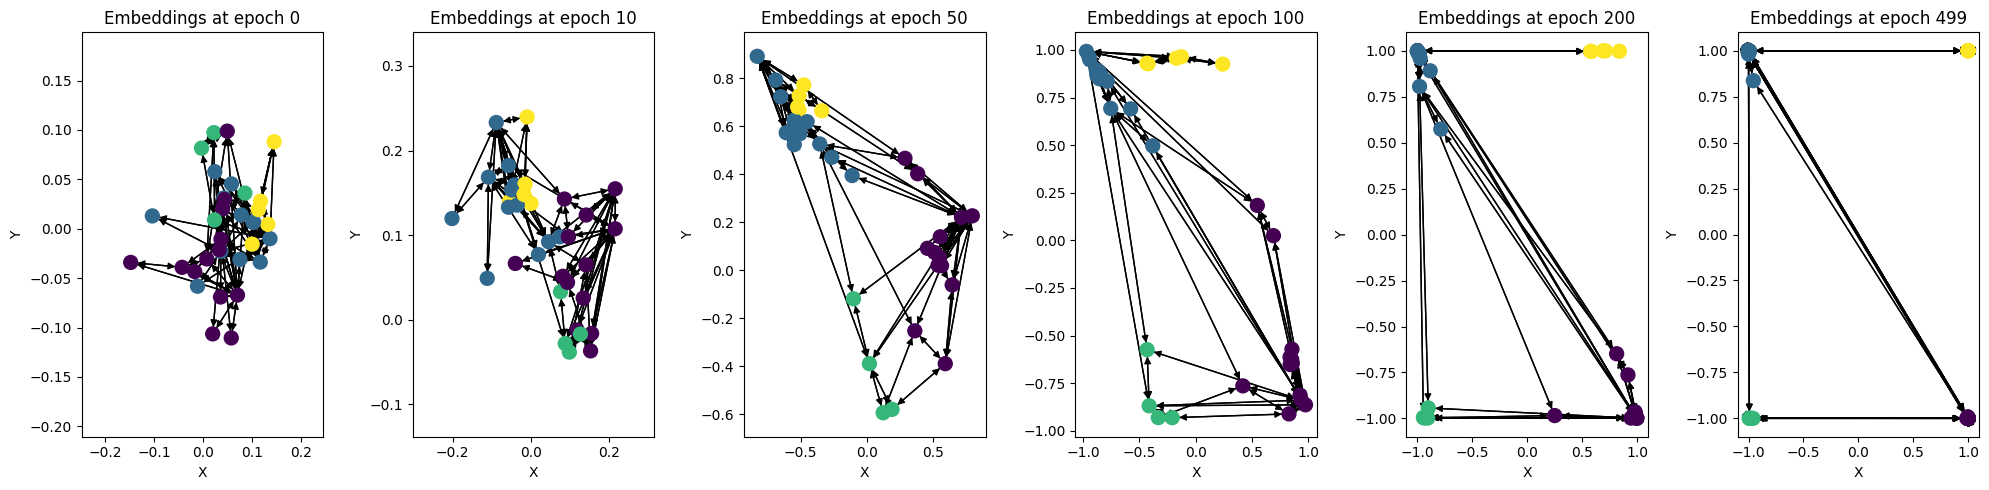

In [62]:
plot_embeddings_overtime(graph_data=data, embeddings=embeddings, plotting_epochs=plotting_epochs)